### Classification Problem

In [1]:
# Fetch the MNIST dataset 

from sklearn.datasets import fetch_mldata
mnist = fetch_mldata('MNIST original')
mnist


{'COL_NAMES': ['label', 'data'],
 'DESCR': 'mldata.org dataset: mnist-original',
 'data': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ..., 
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 'target': array([ 0.,  0.,  0., ...,  9.,  9.,  9.])}

In [2]:
X, y = mnist["data"], mnist["target"]
X.shape

(70000, 784)

In [3]:
y.shape

(70000,)

### Look at the Images

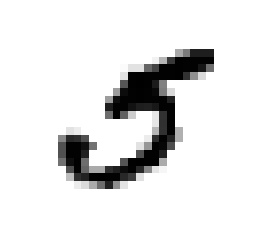

In [8]:
# Let's take a look at one of images

%matplotlib inline
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

some_digit = X[36000] # Digit 36000 out of 70000 images
some_digit_image = some_digit.reshape(28,28) #28x28 pixels reshape it to a 28x28 array

plt.imshow(some_digit_image, cmap = matplotlib.cm.binary, interpolation = "nearest") # Display using Matplotlib's imshow()
plt.axis("off")
plt.show()

           

In [9]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = matplotlib.cm.binary,
               interpolation="nearest")
    plt.axis("off")
    

In [10]:
# EXTRA
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = matplotlib.cm.binary, **options)
    plt.axis("off")
    

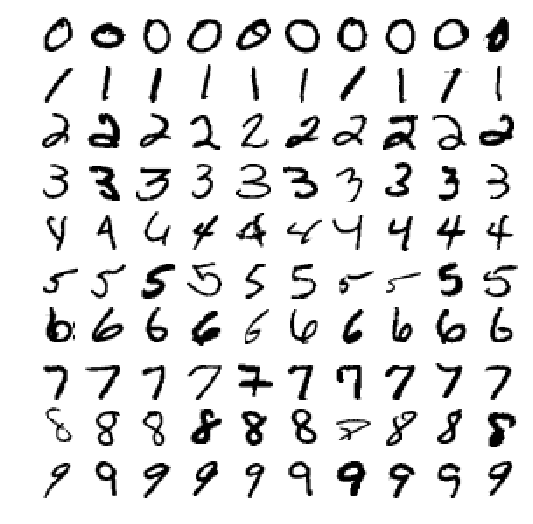

In [12]:
plt.figure(figsize=(9,9))
example_images = np.r_[X[:12000:600], X[13000:30600:600], X[30600:60000:590]]
plot_digits(example_images, images_per_row=10)
plt.show()


In [6]:
# Label tells us that this image is indeed a 5

y[36000]


5.0

### Train/Test/Split and Shuffle

In [13]:
# MNIST dataset already split into a training set and a test set

X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]


In [14]:
# Let's shuffle our training set 

import numpy as np

shuffle_index = np.random.permutation(60000)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]


### Training a Binary Classifier

In [15]:
# Create the target vectors for classification task

y_train_5 = (y_train == 5) # True for all 5s, False for all other digits in dataset
y_test_5 = (y_test == 5)



### SGD Classifier Fit to Model

In [16]:
# Let's use a Stochastic Gradient Descent (SGD) classifier since we have a large dataset
# Stochastic means random aka SGD relies on randomness during training
from sklearn.linear_model import SGDClassifier 

sgd_clf = SGDClassifier(max_iter = 5, tol = None ,random_state=42)
sgd_clf.fit(X_train, y_train_5)


SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=5, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=42, shuffle=True,
       tol=None, verbose=0, warm_start=False)

In [13]:
# The classifier below guesses that the "some_digit" represents 5(True) in the boolean

sgd_clf.predict([some_digit])


array([ True], dtype=bool)

### Performance Measures - Evaluating Your Model

A good way to evaluate your model is to use cross-validation.  

In [17]:
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")


array([ 0.96355,  0.9616 ,  0.9567 ])

Wow, above 96% accuracy! (ratio of correct predictions) on all cross-validation folds.  Before we get too excited about our classifier let's try a very basic, simple classifier to compare. 

In [18]:

from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=42)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = (y_train_5[train_index])
    X_test_fold = X_train[test_index]
    y_test_fold = (y_train_5[test_index])

    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))
    

0.96355
0.9616
0.9567


In [19]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)
    

In [20]:
never_5_clf = Never5Classifier()


In [21]:
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")


array([ 0.91185,  0.91065,  0.90645])

It has over 90% accuracy.  This is simply because only about 10% of the images are 5s, so if you always guess that an image is not a 5, you will be right about 90% of the time.  This demonstrates that accuracy is not the preferred performance measure to use.  Let's take a look at confusion matrix.  This is a much better way to evaluate the performance of a classifier.  The general idea is to count the number of times instances of class A are classified as class B.  In our example, to know the number of times the classifier confused images of 5s with 3s.  Here we would look at the 5th row and 3rd column of the confusion matrix.

In [31]:
# Predictions made on each test fold using cross_val_predict ()

from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)


### Confusion Matrix, Precision, Recall, F1 Score

In [32]:
# Confusion matrix () function

from sklearn.metrics import confusion_matrix

In [33]:
confusion_matrix(y_train_5, y_train_pred) # Pass the target classes and predicted classes


array([[53179,  1400],
       [  963,  4458]])

In [34]:
y_train_perfect_predictions = y_train_5

In [35]:
confusion_matrix(y_train_5, y_train_perfect_predictions)


array([[54579,     0],
       [    0,  5421]])

Each row in a confusion matrix represents an actual class, while each column represents a predicted class.  The first row of this matrix considers the non-5 images (negative class): 52,417 - number correctly classified as non-5s (true negatives), while the remaining 2,162 were wrongly classified as 5s (false positives).  The second row considers the images of 5s (positive class): 985 were wrongly classified as non-5s (false negatives), while the remaining 4,436 were correctly classified as 5s (true positives).  

Another, yet less informative metric to use is precision.  It tells you the positive predictions.  Precision = TP/TP + FP.  Often precision can be seen with another metric named recall, also called sensitivity or true positive rate (TPR): recall = TP/TP + FN.

In [40]:
4458 / (4458 + 1400)

0.7610105838170024

In [41]:
from sklearn.metrics import precision_score, recall_score

precision_score(y_train_5, y_train_pred)

0.76101058381700237

In [42]:
4458 / (4458 + 963)

0.8223574986164914

In [43]:
recall_score(y_train_5, y_train_pred)

0.82235749861649143

Precision/Recall Tradeoff - Increasing precision reduces recall, and vice versa.  We can see this above.

In [50]:
# Combine precision and recall and look at F1 score
# Note - better to use the F1 score when precision and recall scores are similar
# Harmonic mean of precision and recall

from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)


0.79049561131305957

### Setting a Decision Threshold

In [51]:
# Let's play around with the decision_function () in Sklearn 
# which returns a score for each instance where we can make predictions 

y_scores = sgd_clf.decision_function([some_digit])
y_scores


array([ 78908.18246124])

In [52]:
threshold = 200000

In [53]:
y_some_digit_pred = (y_scores > threshold)

In [54]:
y_some_digit_pred

array([False], dtype=bool)

The above confirms that raising the threshold decreases recall.

How can you determine which threshold to use?  First need to get the scores of all instances in the training set using cross_val_predict() function again, but this time specifying that you want it to return decision scores instead of predictions.

In [55]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method = "decision_function")


In [56]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)


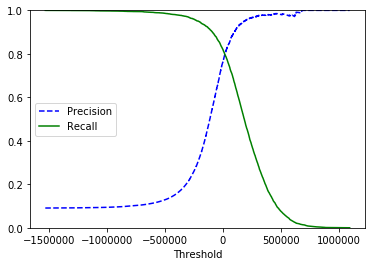

In [57]:
# Plot precision and recall as functions of threshold value using Matplotlib

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.xlabel("Threshold")
    plt.legend(loc="center left")
    plt.ylim([0, 1])
    
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()



### ROC Curves

The ROC Curve - receiver operating characteristic (ROC) curve is another common metric to use with binary classifiers.  It is similar to the precision/recall curve, but this plots the true positive rate(or recall) against the false positive rate.  The FPR is the ratio of negative instances that are incorrectly classified as positive.  It is equal to 1 - true negative rate, which is the ratio of negative instances that are correctly classified as negative.  TNR is also called specificty.  Thus, the ROC curve plots sensitivity (revall) versus 1 - specificity.

In [58]:
# Plot the ROC curve after you compute TPR and FPR for various thresholds, using roc_curve() function

from sklearn.metrics import roc_curve


fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)



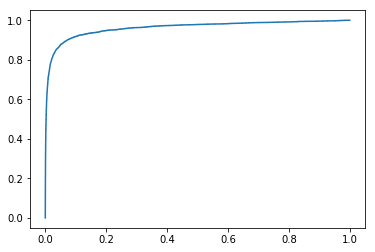

In [59]:
plt.plot(fpr, tpr)

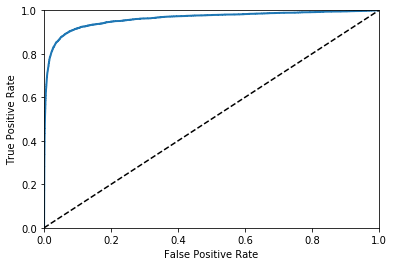

In [60]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0,1], [0,1], 'k--')
    plt.axis([0,1,0,1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    
plot_roc_curve(fpr, tpr)
plt.show()


In [61]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)


0.96166584906858554

### Fit a RandomForest Classifier for Comparison

In [62]:
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3,
                                    method="predict_proba")


In [63]:
y_scores_forest = y_probas_forest[:, 1] # score = proba of positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5,y_scores_forest)

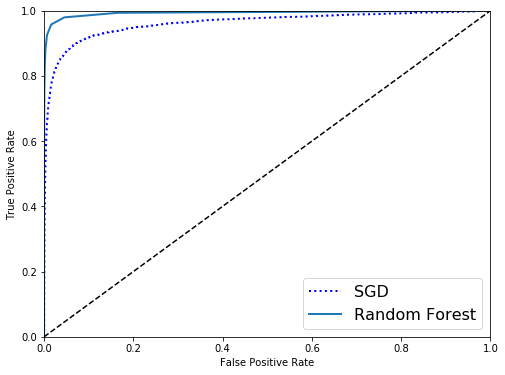

In [65]:
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, "b:", linewidth=2, label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right", fontsize=16)

plt.show()

In [66]:
roc_auc_score(y_train_5, y_scores_forest)


0.99312194536976617

In [67]:
y_train_pred_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3)
precision_score(y_train_5, y_train_pred_forest)

0.98181419807186676

In [68]:
recall_score(y_train_5, y_train_pred_forest)

0.82660025825493455

### Scaling the Inputs

In [22]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler ()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))



In [23]:
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([ 0.90711858,  0.9099455 ,  0.91208681])

### Error Analysis

After you have tried out multiple models, fine-tuned their hyperparameters using GridSearchCV, assuming you have found the most promising model and you want to find ways to improve it. One way is by analyzing the types of errors it makes.

In [24]:
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_predict

In [25]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)

In [50]:
conf_mx = confusion_matrix(y_train, y_train_pred)


In [52]:
conf_mx

array([[5744,    2,   21,   13,   11,   39,   44,    8,   38,    3],
       [   2, 6457,   52,   23,    5,   45,    6,   11,  130,   11],
       [  54,   35, 5358,   96,   84,   25,   82,   58,  151,   15],
       [  50,   38,  133, 5338,    3,  240,   31,   56,  145,   97],
       [  22,   24,   40,   11, 5369,    9,   49,   37,   89,  192],
       [  68,   32,   42,  188,   78, 4598,  104,   26,  190,   95],
       [  31,   26,   53,    2,   37,   82, 5632,    5,   48,    2],
       [  22,   17,   75,   28,   49,   12,    6, 5831,   15,  210],
       [  49,  148,   80,  147,   13,  163,   57,   30, 5020,  144],
       [  37,   31,   28,   86,  162,   37,    2,  234,   85, 5247]])

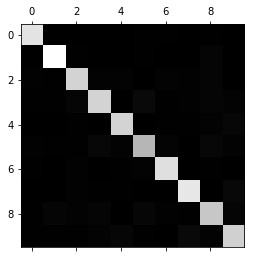

In [53]:
# For clarity, let's look at an image representation of the conf_mx using Matplotlib matshow () function

import matplotlib.pyplot as plt
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()


The above confusion matrix looks fairly good, since most images are on the main diagonal, which means that they were classified correctly.  The 5s look slightly darker than the other digits, which could mean that there are fewer images of 5s in the dataset or that the classifier does not perform as well on 5s as on other digits.  Overall, analyzing the confusion matrix can give insights on ways to improve your classifier.

In [62]:
# Divide each value in the confusion matrix by the number of images in corresponding class
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums


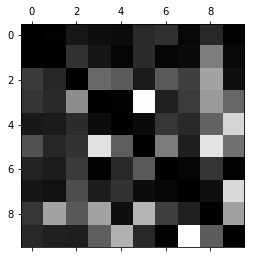

In [63]:
# Now let's fill in the diagonal with zeros to keep only the errors, plot the results

np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)


### Multiclass Classification

In [26]:
sgd_clf.fit(X_train, y_train)

SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=5, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=42, shuffle=True,
       tol=None, verbose=0, warm_start=False)

In [55]:
sgd_clf.predict([some_digit])


array([ 0.])

In [56]:
some_digit_scores =sgd_clf.decision_function([some_digit])


In [57]:
some_digit_scores

array([[ -50186.18601346, -531796.02762747, -195789.29126308,
        -302100.03673388, -389761.10238171,  -62601.85131841,
        -755367.17742765, -374470.58806283, -647689.82574714,
        -632856.09206898]])

In [58]:
np.argmax(some_digit_scores)


0

In [59]:
sgd_clf.classes_

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9.])

In [60]:
sgd_clf.classes_[5]


5.0

In [27]:
# Before scaling the inputs, scroll above to see after scaling and the improvement in accuracy

cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring = "accuracy")


array([ 0.82903419,  0.86539327,  0.87178077])

Above 86% on all test folds but there is room for improvement via scaling the inputs.

### Scaling the Inputs

In [69]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")


array([ 0.91091782,  0.90849542,  0.91053658])

After scaling the inputs we achieve above 90% on all test folds.

### Confusion Matrix

In [70]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5728,    3,   18,   14,   13,   49,   49,    8,   38,    3],
       [   2, 6492,   43,   26,    4,   37,    8,   10,  106,   14],
       [  51,   35, 5323,  106,   79,   28,   85,   61,  177,   13],
       [  43,   40,  139, 5337,    2,  246,   38,   59,  140,   87],
       [  17,   28,   29,    8, 5364,   10,   60,   38,   76,  212],
       [  67,   39,   34,  171,   70, 4625,  110,   32,  181,   92],
       [  34,   21,   43,    2,   36,   94, 5632,    7,   49,    0],
       [  18,   21,   66,   26,   52,   11,    6, 5819,   14,  232],
       [  52,  146,   63,  161,   15,  169,   60,   31, 5016,  138],
       [  44,   28,   28,   85,  158,   38,    2,  222,   81, 5263]])

In [71]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

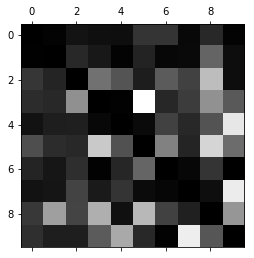

In [73]:
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)

plt.show()